In [3]:
#Importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
import os
import matplotlib.pyplot as plt#visualization
from collections import Counter
from PIL import  Image
%matplotlib inline
import pandas as pd
import seaborn as sns #visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

import xgboost as xgb
import catboost as catb
import lightgbm as lgbm
from imblearn.over_sampling import RandomOverSampler, ADASYN, BorderlineSMOTE, SMOTE

from scipy.stats import shapiro, probplot, ttest_ind, mannwhitneyu, chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, scorer
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score, cohen_kappa_score
from sklearn.model_selection import KFold, GridSearchCV
import statsmodels.api as sm
from yellowbrick.classifier import DiscriminationThreshold



pd.set_option('display.max_columns', 500)

1. повторить анализ набора данных WA_Fn-UseC_-Telco-Customer-Churn.csv (желательно придумать какие-то дополнительные признаки)

In [4]:
telcom = pd.read_csv(r"./WA_Fn-UseC_-Telco-Customer-Churn.csv")
telcom.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

### Data

In [5]:
print ("Rows     : " ,telcom.shape[0])
print ("Columns  : " ,telcom.shape[1])
print ("\nFeatures : \n" ,telcom.columns.tolist())
print ("\nMissing values :  ", telcom.isnull().sum().values.sum())
print ("\nUnique values :  \n",telcom.nunique())

Rows     :  7043
Columns  :  21

Features : 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values :   0

Unique values :  
 customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


### Data manipulation

In [6]:
telcom['TotalCharges'].value_counts()

20.2       11
           11
19.75       9
19.9        8
20.05       8
           ..
3539.25     1
3708.4      1
5769.75     1
3330.1      1
461.3       1
Name: TotalCharges, Length: 6531, dtype: int64

In [7]:
#Replacing spaces with null values in total charges column
telcom['TotalCharges'] = telcom["TotalCharges"].replace(" ",np.nan)

#Dropping null values from total charges column which contain .15% missing data 
telcom2 = telcom[telcom["TotalCharges"].notnull()]
telcom2.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [8]:
telcom2.shape

(7032, 21)

In [9]:
#convert to float type
telcom2["TotalCharges"] = telcom2["TotalCharges"].astype(float)

In [10]:
telcom2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [11]:
#replace 'No internet service' to No for the following columns
replace_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    telcom2[i]  = telcom2[i].replace({'No internet service' : 'No'})
    
#replace values
telcom2["SeniorCitizen"] = telcom2["SeniorCitizen"].replace({1:"Yes",0:"No"})

In [12]:
#Tenure to categorical column
def tenure_lab(x_tenure) :
    
    if x_tenure <= 3:
        return "Tenure_0-3"
    elif (x_tenure > 3) & (x_tenure <= 6 ):
        return "Tenure_3-6"
    elif (x_tenure > 6) & (x_tenure <= 9 ):
        return "Tenure_6-9"
    elif (x_tenure > 9) & (x_tenure <= 12 ):
        return "Tenure_9-12"
    elif (x_tenure > 12) & (x_tenure <= 18 ):
        return "Tenure_12-18"
    elif (x_tenure > 18) & (x_tenure <= 24 ):
        return "Tenure_18-24"
    elif (x_tenure > 24) & (x_tenure <= 36) :
        return "Tenure_24-36"
    elif (x_tenure > 36) & (x_tenure <= 48) :
        return "Tenure_36-48"
    elif (x_tenure > 48) & (x_tenure <= 60) :
        return "Tenure_48-60"
    elif x_tenure > 60 :
        return "Tenure_gt_60"

telcom2["tenure_group"] = telcom2['tenure'].apply(lambda x: tenure_lab(x))

In [13]:
def set_use_services(telcom_df):
    if (telcom_df['StreamingTV'] == 'Yes' 
       ) or (telcom_df['StreamingMovies'] == 'Yes'
            ) or (telcom_df['DeviceProtection'] == 'Yes'
                 ) or (telcom_df['TechSupport'] == 'Yes'):
        return 'Yes'
    else:
        return 'No'

telcom2['UseOnlineServices'] = telcom2.apply(lambda x: set_use_services(x), axis = 1)

In [14]:
def set_use_streaming(telcom_df):
    if (telcom_df['StreamingTV'] == 'Yes'
       ) or (telcom_df['StreamingMovies'] == 'Yes'):
        return 'Yes'
    else:
        return 'No'

telcom2['UseStreaming'] = telcom2.apply(lambda x: set_use_streaming(x), axis = 1)

In [15]:
telcom2['TotalChargesPerTenure'] = telcom2['TotalCharges'] / telcom2['tenure']
telcom2['MonthlyChargesPerTotalCharges'] = telcom2['MonthlyCharges'] / telcom2['TotalCharges']

In [16]:
#Separating churn and non churn customers
churn     = telcom2[telcom2["Churn"] == "Yes"]
not_churn = telcom2[telcom2["Churn"] == "No"]

#Separating catagorical and numerical columns
Id_col     = ['customerID']
target_col = ["Churn"]
cat_cols   = telcom2.nunique()[telcom2.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in telcom2.columns if x not in cat_cols + target_col + Id_col]

In [17]:
telcom2.head(20)

customerID  gender SeniorCitizen Partner Dependents  tenure PhoneService  \
0   7590-VHVEG  Female            No     Yes         No       1           No   
1   5575-GNVDE    Male            No      No         No      34          Yes   
2   3668-QPYBK    Male            No      No         No       2          Yes   
3   7795-CFOCW    Male            No      No         No      45           No   
4   9237-HQITU  Female            No      No         No       2          Yes   
5   9305-CDSKC  Female            No      No         No       8          Yes   
6   1452-KIOVK    Male            No      No        Yes      22          Yes   
7   6713-OKOMC  Female            No      No         No      10           No   
8   7892-POOKP  Female            No     Yes         No      28          Yes   
9   6388-TABGU    Male            No      No        Yes      62          Yes   
10  9763-GRSKD    Male            No     Yes        Yes      13          Yes   
11  7469-LKBCI    Male            No      No         No      16          Yes   
12  8091-TTVAX    Male            No     Yes         No      58          Yes   
13  0280-XJGEX    Male            No      No         No      49          Yes   
14  5129-JLPIS    Male            No      No         No      25          Yes   
15  3655-SNQYZ  Female            No     Yes        Yes      69          Yes   
16  8191-XWSZG  Female            No      No         No      52          Yes   
17  9959-WOFKT    Male            No      No        Yes      71          Yes   
18  4190-MFLUW  Female            No     Yes        Yes      10          Yes   
19  4183-MYFRB  Female            No      No         No      21          Yes   

       MultipleLines InternetService OnlineSecurity OnlineBackup  \
0   No phone service             DSL             No          Yes   
1                 No             DSL            Yes           No   
2                 No             DSL            Yes          Yes   
3   No phone service             DSL            Yes           No   
4                 No     Fiber optic             No           No   
5                Yes     Fiber optic             No           No   
6                Yes     Fiber optic             No          Yes   
7   No phone service             DSL            Yes           No   
8                Yes     Fiber optic             No           No   
9                 No             DSL            Yes          Yes   
10                No             DSL            Yes           No   
11                No              No             No           No   
12               Yes     Fiber optic             No           No   
13               Yes     Fiber optic             No          Yes   
14                No     Fiber optic            Yes           No   
15               Yes     Fiber optic            Yes          Yes   
16                No              No             No           No   
17               Yes     Fiber optic            Yes           No   
18                No             DSL             No           No   
19                No     Fiber optic             No          Yes   

   DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0                No          No          No              No  Month-to-month   
1               Yes          No          No              No        One year   
2                No          No          No              No  Month-to-month   
3               Yes         Yes          No              No        One year   
4                No          No          No              No  Month-to-month   
5               Yes          No         Yes             Yes  Month-to-month   
6                No          No         Yes              No  Month-to-month   
7                No          No          No              No  Month-to-month   
8               Yes         Yes         Yes             Yes  Month-to-month   
9                No          No          No              No        One year   
10               No      

### EDA

In [18]:
telcom2.corr()

tenure  MonthlyCharges  TotalCharges  \
tenure                         1.000000        0.246862      0.825880   
MonthlyCharges                 0.246862        1.000000      0.651065   
TotalCharges                   0.825880        0.651065      1.000000   
TotalChargesPerTenure          0.246198        0.996237      0.650915   
MonthlyChargesPerTotalCharges -0.594482       -0.185553     -0.462415   

                               TotalChargesPerTenure  \
tenure                                      0.246198   
MonthlyCharges                              0.996237   
TotalCharges                                0.650915   
TotalChargesPerTenure                       1.000000   
MonthlyChargesPerTotalCharges              -0.187348   

                               MonthlyChargesPerTotalCharges  
tenure                                             -0.594482  
MonthlyCharges                                     -0.185553  
TotalCharges                                       -0.462415  
TotalChargesPerTenure                              -0.187348  
MonthlyChargesPerTotalCharges                       1.000000

In [19]:
#labels
lab = telcom2["Churn"].value_counts().keys().tolist()
#values
val = telcom2["Churn"].value_counts().values.tolist()

trace = go.Pie(labels = lab ,
               values = val ,
               marker = dict(colors =  [ 'royalblue' ,'lime'],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Customer attrition in data",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig)

In [21]:
#function  for pie plot for customer attrition types
def plot_pie(column) :
    
    trace1 = go.Pie(values  = churn[column].value_counts().values.tolist(),
                    labels  = churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Churn Customers",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    hole    = .6
                   )
    trace2 = go.Pie(values  = not_churn[column].value_counts().values.tolist(),
                    labels  = not_churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Non churn customers" 
                   )


    layout = go.Layout(dict(title = column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .15, y = .5),
                                           dict(text = "Non churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .88,y = .5
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)


#function  for histogram for customer attrition types
def histogram(column) :
    trace1 = go.Histogram(x  = churn[column],
                          histnorm= "percent",
                          name = "Churn Customers",
                          marker = dict(line = dict(width = .5,
                                                    color = "black"
                                                    )
                                        ),
                         opacity = .9 
                         ) 
    
    trace2 = go.Histogram(x  = not_churn[column],
                          histnorm = "percent",
                          name = "Non churn customers",
                          marker = dict(line = dict(width = .5,
                                              color = "black"
                                             )
                                 ),
                          opacity = .9
                         )
    
    data = [trace1,trace2]
    layout = go.Layout(dict(title =column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = column,
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                           )
                      )
    fig  = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)
    
#function  for scatter plot matrix  for numerical columns in data
def scatter_matrix(df)  :
    
    df  = df.sort_values(by = "Churn" ,ascending = True)
    classes = df["Churn"].unique().tolist()
    classes
    
    class_code  = {classes[k] : k for k in range(2)}
    class_code

    color_vals = [class_code[cl] for cl in df["Churn"]]
    color_vals

    pl_colorscale = "Portland"

    pl_colorscale

    text = [df.loc[k,"Churn"] for k in range(len(df))]
    text

    trace = go.Splom(dimensions = [dict(label  = "tenure",
                                       values = df["tenure"]),
                                  dict(label  = 'MonthlyCharges',
                                       values = df['MonthlyCharges']),
                                  dict(label  = 'TotalCharges',
                                       values = df['TotalCharges'])],
                     text = text,
                     marker = dict(color = color_vals,
                                   colorscale = pl_colorscale,
                                   size = 3,
                                   showscale = False,
                                   line = dict(width = .1,
                                               color='rgb(230,230,230)'
                                              )
                                  )
                    )
    axis = dict(showline  = True,
                zeroline  = False,
                gridcolor = "#fff",
                ticklen   = 4
               )
    
    layout = go.Layout(dict(title  = 
                            "Scatter plot matrix for Numerical columns for customer attrition",
                            autosize = False,
                            height = 800,
                            width  = 800,
                            dragmode = "select",
                            hovermode = "closest",
                            plot_bgcolor  = 'rgba(240,240,240, 0.95)',
                            xaxis1 = dict(axis),
                            yaxis1 = dict(axis),
                            xaxis2 = dict(axis),
                            yaxis2 = dict(axis),
                            xaxis3 = dict(axis),
                            yaxis3 = dict(axis),
                           )
                      )
    data   = [trace]
    fig = go.Figure(data = data,layout = layout )
    py.iplot(fig)

#for all categorical columns plot pie
for i in cat_cols :
    plot_pie(i)

#for all categorical columns plot histogram    
for i in num_cols :
    histogram(i)

#scatter plot matrix
scatter_matrix(telcom2)

KeyError: 488

In [22]:
#cusomer attrition in tenure groups
tg_ch  =  churn["tenure_group"].value_counts().reset_index()
tg_ch.columns  = ["tenure_group","count"]
tg_nch =  not_churn["tenure_group"].value_counts().reset_index()
tg_nch.columns = ["tenure_group","count"]

#bar - churn
trace1 = go.Bar(x = tg_ch["tenure_group"]  , y = tg_ch["count"],
                name = "Churn Customers",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)

#bar - not churn
trace2 = go.Bar(x = tg_nch["tenure_group"] , y = tg_nch["count"],
                name = "Non Churn Customers",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)

layout = go.Layout(dict(title = "Customer attrition in tenure groups",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "tenure group",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "count",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                       )
                  )
data = [trace1,trace2]
fig  = go.Figure(data=data,layout=layout)
py.iplot(fig)

In [23]:
telcom2[['MonthlyCharges', 'TotalCharges','tenure',"tenure_group"]]

#scatter plot monthly charges & total charges by tenure group

def plot_tenure_scatter(tenure_group,color) :
    tracer = go.Scatter(x = telcom[telcom["tenure_group"] == tenure_group]["MonthlyCharges"],
                        y = telcom[telcom["tenure_group"] == tenure_group]["TotalCharges"],
                        mode = "markers",marker = dict(line = dict(color = "black",
                                                                   width = .2),
                                                       size = 4 , color = color,
                                                       symbol = "diamond-dot",
                                                      ),
                        name = tenure_group,
                        opacity = .9
                       )
    return tracer

#scatter plot monthly charges & total charges by churn group
def plot_churncharges_scatter(churn,color) :
    tracer = go.Scatter(x = telcom[telcom["Churn"] == churn]["MonthlyCharges"],
                        y = telcom[telcom["Churn"] == churn]["TotalCharges"],
                        mode = "markers",marker = dict(line = dict(color = "black",
                                                                   width = .2),
                                                       size = 4 , color = color,
                                                       symbol = "diamond-dot",
                                                      ),
                        name = "Churn - " + churn,
                        opacity = .9
                       )
    return tracer

trace1 = plot_tenure_scatter("Tenure_0-12","#FF3300")
trace2 = plot_tenure_scatter("Tenure_12-24","#6666FF")
trace3 = plot_tenure_scatter("Tenure_24-48","#99FF00")
trace4 = plot_tenure_scatter("Tenure_48-60","#996600")
trace5 = plot_tenure_scatter("Tenure_gt_60","grey")
trace6 = plot_churncharges_scatter("Yes","red")
trace7 = plot_churncharges_scatter("No","blue")

data1   = [trace1,trace2,trace3,trace4,trace5] 
data2   = [trace7,trace6]

#layout
def layout_title(title) :
    layout = go.Layout(dict(title = title,
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         title = "Monthly charges",
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         title = "Total Charges",
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            height = 600
                           )
                      )
    return layout

layout1  = layout_title("Monthly Charges & Total Charges by Tenure group")
layout2  = layout_title("Monthly Charges & Total Charges by Churn group")
fig1 = go.Figure(data = data1,layout = layout1)
fig2 = go.Figure(data = data2,layout = layout2)
py.iplot(fig1)
py.iplot(fig2)

KeyError: 'tenure_group'

In [24]:
avg_tgc = telcom2.groupby(["tenure_group","Churn"])[["MonthlyCharges",
                                                    "TotalCharges"]].mean().reset_index()

#function for tracing 
def mean_charges(column,aggregate) :
    tracer = go.Bar(x = avg_tgc[avg_tgc["Churn"] == aggregate]["tenure_group"],
                    y = avg_tgc[avg_tgc["Churn"] == aggregate][column],
                    name = aggregate,marker = dict(line = dict(width = 1)),
                    text = "Churn"
                   )
    return tracer

#function for layout
def layout_plot(title,xaxis_lab,yaxis_lab) :
    layout = go.Layout(dict(title = title,
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = xaxis_lab,
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = yaxis_lab,
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                           )
                      )
    return layout
    

#plot1 - mean monthly charges by tenure groups
trace1  = mean_charges("MonthlyCharges","Yes")
trace2  = mean_charges("MonthlyCharges","No")
layout1 = layout_plot("Average Monthly Charges by Tenure groups",
                      "Tenure group","Monthly Charges")
data1   = [trace1,trace2]
fig1    = go.Figure(data=data1,layout=layout1)

#plot2 - mean total charges by tenure groups
trace3  = mean_charges("TotalCharges","Yes")
trace4  = mean_charges("TotalCharges","No")
layout2 = layout_plot("Average Total Charges by Tenure groups",
                      "Tenure group","Total Charges")
data2   = [trace3,trace4]
fig2    = go.Figure(data=data2,layout=layout2)

py.iplot(fig1)
py.iplot(fig2)

In [25]:
##copy data
tel_df = telcom2.copy()
#Drop tenure column
#telcom = telcom.drop(columns = "tenure_group",axis = 1)



#data = [trace1,trace2]

### Data preprocessing

In [26]:
#customer id col
Id_col     = ['customerID']
#Target columns
target_col = ["Churn"]
#categorical columns
cat_cols   = tel_df.nunique()[tel_df.nunique() < 11].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in tel_df.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = tel_df.nunique()[tel_df.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    tel_df[i] = le.fit_transform(tel_df[i])
    
#Duplicating columns for multi value columns
tel_df = pd.get_dummies(data = tel_df,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(tel_df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_telcom_og = tel_df.copy()
tel_df = tel_df.drop(columns = num_cols,axis = 1)
tel_df = tel_df.merge(scaled,left_index=True,right_index=True,how = "left")

In [27]:
summary = (df_telcom_og[[i for i in df_telcom_og.columns if i not in Id_col]].
           describe().transpose().reset_index())

summary = summary.rename(columns = {"index" : "feature"})
summary = np.around(summary,3)

val_lst = [summary['feature'], summary['count'],
           summary['mean'],summary['std'],
           summary['min'], summary['25%'],
           summary['50%'], summary['75%'], summary['max']]

trace  = go.Table(header = dict(values = summary.columns.tolist(),
                                line = dict(color = ['#506784']),
                                fill = dict(color = ['#119DFF']),
                               ),
                  cells  = dict(values = val_lst,
                                line = dict(color = ['#506784']),
                                fill = dict(color = ["lightgrey",'#F5F8FF'])
                               ),
                  columnwidth = [200,60,100,100,60,60,80,80,80])
layout = go.Layout(dict(title = "Variable Summary"))
figure = go.Figure(data=[trace],layout=layout)
py.iplot(figure)

In [28]:
#correlation
correlation = telcom2.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix for variables",
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data = [trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

X = df_telcom_og[[i for i in df_telcom_og.columns if i not in Id_col + target_col]]
Y = df_telcom_og[target_col + Id_col]

principal_components = pca.fit_transform(X)
pca_data = pd.DataFrame(principal_components,columns = ["PC1","PC2"])
pca_data = pca_data.merge(Y,left_index=True,right_index=True,how="left")
pca_data["Churn"] = pca_data["Churn"].replace({1:"Churn",0:"Not Churn"})

def pca_scatter(target,color) :
    tracer = go.Scatter(x = pca_data[pca_data["Churn"] == target]["PC1"] ,
                        y = pca_data[pca_data["Churn"] == target]["PC2"],
                        name = target,mode = "markers",
                        marker = dict(color = color,
                                      line = dict(width = .5),
                                      symbol =  "diamond-open"),
                        text = ("Customer Id : " + 
                                pca_data[pca_data["Churn"] == target]['customerID'])
                       )
    return tracer

layout = go.Layout(dict(title = "Visualising data with principal components",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "principal component 1",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "principal component 2",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        height = 600
                       )
                  )
trace1 = pca_scatter("Churn",'red')
trace2 = pca_scatter("Not Churn",'royalblue')
data = [trace2,trace1]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

In [30]:
#separating binary columns
bi_cs = df_telcom_og.nunique()[df_telcom_og.nunique() == 2].keys()
dat_rad = df_telcom_og[bi_cs]

#plotting radar chart for churn and non churn customers(binary variables)
def plot_radar(df,aggregate,title) :
    data_frame = df[df["Churn"] == aggregate] 
    data_frame_x = data_frame[bi_cs].sum().reset_index()
    data_frame_x.columns  = ["feature","yes"]
    data_frame_x["no"]    = data_frame.shape[0]  - data_frame_x["yes"]
    data_frame_x  = data_frame_x[data_frame_x["feature"] != "Churn"]
    
    #count of 1's(yes)
    trace1 = go.Scatterpolar(r = data_frame_x["yes"].values.tolist(),
                             theta = data_frame_x["feature"].tolist(),
                             fill  = "toself",name = "count of 1's",
                             mode = "markers+lines",
                             marker = dict(size = 5)
                            )
    #count of 0's(No)
    trace2 = go.Scatterpolar(r = data_frame_x["no"].values.tolist(),
                             theta = data_frame_x["feature"].tolist(),
                             fill  = "toself",name = "count of 0's",
                             mode = "markers+lines",
                             marker = dict(size = 5)
                            ) 
    layout = go.Layout(dict(polar = dict(radialaxis = dict(visible = True,
                                                           side = "counterclockwise",
                                                           showline = True,
                                                           linewidth = 2,
                                                           tickwidth = 2,
                                                           gridcolor = "white",
                                                           gridwidth = 2),
                                         angularaxis = dict(tickfont = dict(size = 10),
                                                            layer = "below traces"
                                                           ),
                                         bgcolor  = "rgb(243,243,243)",
                                        ),
                            paper_bgcolor = "rgb(243,243,243)",
                            title = title,height = 700))
    
    data = [trace2,trace1]
    fig = go.Figure(data=data,layout=layout)
    py.iplot(fig)

#plot
plot_radar(dat_rad,1,"Churn -  Customers")
plot_radar(dat_rad,0,"Non Churn - Customers")

### Modelling

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1268
           1       0.69      0.51      0.59       490

    accuracy                           0.80      1758
   macro avg       0.76      0.71      0.73      1758
weighted avg       0.79      0.80      0.79      1758

Accuracy   Score :  0.800910125142207
Area under curve :  0.7129788192879676 



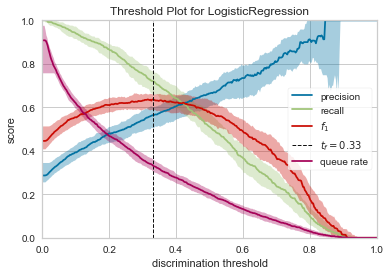

In [31]:
#splitting train and test data 
train,test = train_test_split(df_telcom_og,test_size = .25 ,random_state = 111)
    
##seperating dependent and independent variables
cols    = [i for i in df_telcom_og.columns if i not in Id_col + target_col]
train_X = train[cols]
train_Y = train[target_col]
test_X  = test[cols]
test_Y  = test[target_col]

#Function attributes
#dataframe     - processed dataframe
#Algorithm     - Algorithm used 
#training_x    - predictor variables dataframe(training)
#testing_x     - predictor variables dataframe(testing)
#training_y    - target variable(training)
#training_y    - target variable(testing)
#cf - ["coefficients","features"](cooefficients for logistic 
                                 #regression,features for tree based models)

#threshold_plot - if True returns threshold plot for model
    
def telecom_churn_prediction(algorithm,training_x,testing_x,
                             training_y,testing_y,cols,cf,threshold_plot) :
    
    #model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    #coeffs
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df     = pd.DataFrame(cols)
    coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix ,
                        x = ["Not churn","Churn"],
                        y = ["Not churn","Churn"],
                        showscale  = False,colorscale = "Picnic",
                        name = "matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    #plot coeffs
    trace4 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Picnic",
                                  line = dict(width = .6,color = "black")))
    
    #subplots
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver operating characteristic',
                                            'Feature Importances'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    fig.append_trace(trace4,2,1)
    
    fig['layout'].update(showlegend=False, title="Model performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis3"].update(dict(showgrid = True,tickfont = dict(size = 10),
                                        tickangle = 90))
    py.iplot(fig)
    
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()
        
logit_simple  = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

telecom_churn_prediction(logit_simple,train_X,test_X,train_Y,test_Y,
                         cols,"coefficients",threshold_plot = True)

### SMOTE

- Randomly pick a point from the minority class.
- Compute the k-nearest neighbors (for some pre-specified k) for this point.
- Add k new points somewhere between the chosen point and each of its neighbors

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

 Classification report : 
               precision    recall  f1-score   support

           0       0.85      0.86      0.86      1268
           1       0.63      0.60      0.61       490

    accuracy                           0.79      1758
   macro avg       0.74      0.73      0.73      1758
weighted avg       0.79      0.79      0.79      1758

Accuracy   Score :  0.7895335608646189
Area under curve :  0.7307619262215926 



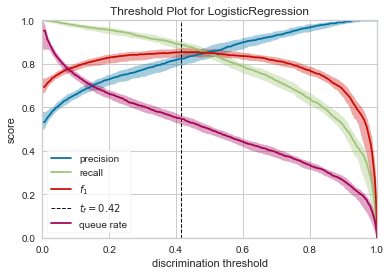

In [32]:
cols = [i for i in df_telcom_og.columns if i not in Id_col+target_col]

smote_X = df_telcom_og[cols]
smote_Y = df_telcom_og[target_col]

#Split train and test data
smote_train_X,smote_test_X,smote_train_Y,smote_test_Y = train_test_split(smote_X, smote_Y,
                                                                         test_size = .25 ,
                                                                         random_state = 111)

#oversampling minority class using smote
os = SMOTE(random_state = 0)
os_smote_X, os_smote_Y = os.fit_sample(smote_train_X,smote_train_Y)
os_smote_X = pd.DataFrame(data = os_smote_X,columns=cols)
os_smote_Y = pd.DataFrame(data = os_smote_Y,columns=target_col)
###



logit_smote = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

telecom_churn_prediction(logit_smote, os_smote_X, test_X, os_smote_Y, test_Y,
                         cols, "coefficients", threshold_plot = True)

### Feature selection

Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [33]:
test_X.shape

(1758, 42)

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

 Classification report : 
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      1268
           1       0.63      0.62      0.63       490

    accuracy                           0.79      1758
   macro avg       0.74      0.74      0.74      1758
weighted avg       0.79      0.79      0.79      1758

Accuracy   Score :  0.7935153583617748
Area under curve :  0.7416613017446726 



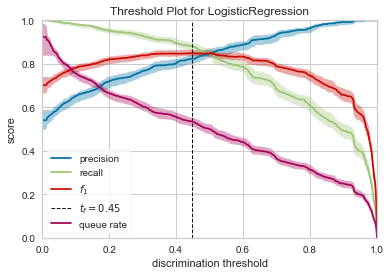

In [34]:
from sklearn.feature_selection import RFE

logit = LogisticRegression()

rfe = RFE(logit, 20)
rfe = rfe.fit(os_smote_X,os_smote_Y.values.ravel())

rfe.support_
rfe.ranking_

#identified columns Recursive Feature Elimination
idc_rfe = pd.DataFrame({"rfe_support" :rfe.support_,
                       "columns" : [i for i in df_telcom_og.columns if i not in Id_col + target_col],
                       "ranking" : rfe.ranking_,
                      })
cols = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist()


#separating train and test data
train_rf_X = os_smote_X[cols]
train_rf_Y = os_smote_Y
test_rf_X  = test[cols]
test_rf_Y  = test[target_col]

logit_rfe = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
#applying model
telecom_churn_prediction(logit_rfe,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                         cols,"coefficients",threshold_plot = True)

tab_rk = ff.create_table(idc_rfe)
py.iplot(tab_rk)

### chi-square

- Feature Extraction with Univariate Statistical Tests (Chi-squared for classification)
- uses the chi squared (chi^2) statistical test for non-negative features to select the best features

In [35]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

#select columns
cols = [i for i in df_telcom_og.columns if i not in Id_col + target_col ]

#dataframe with non negative values
df_x = df_telcom_og[cols]
df_y = df_telcom_og[target_col]

#fit model with k= 3
select = SelectKBest(score_func = chi2, k = 3)
fit    = select.fit(df_x, df_y)

#Summerize scores
print ("scores")
print (fit.scores_)
print ("P - Values")
print (fit.pvalues_)

#create dataframe
score = pd.DataFrame({"features":cols, "scores":fit.scores_, "p_values":fit.pvalues_ })
score = score.sort_values(by = "scores", ascending =False)


#createing new label for categorical and numerical columns
score["feature_type"] = np.where(score["features"].isin(num_cols), "Numerical", "Categorical")

#plot
trace  = go.Scatter(x = score[score["feature_type"] == "Categorical"]["features"],
                    y = score[score["feature_type"] == "Categorical"]["scores"],
                    name = "Categorial",mode = "lines+markers",
                    marker = dict(color = "red",
                                  line = dict(width =1))
                   )

trace1 = go.Bar(x = score[score["feature_type"] == "Numerical"]["features"],
                y = score[score["feature_type"] == "Numerical"]["scores"],name = "Numerical",
                marker = dict(color = "royalblue",
                              line = dict(width =1)),
                xaxis = "x2",yaxis = "y2"
               )
layout = go.Layout(dict(title = "Scores for Categorical & Numerical features",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     tickfont = dict(size =10),
                                     domain=[0, 0.7],
                                     tickangle = 90,zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "scores",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(b=200),
                        xaxis2=dict(domain=[0.8, 1],tickangle = 90,
                                    gridcolor = 'rgb(255, 255, 255)'),
                        yaxis2=dict(anchor='x2',gridcolor = 'rgb(255, 255, 255)')
                        )
                  )

data=[trace,trace1]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

scores
[2.54297062e-01 1.33482766e+02 8.18577694e+01 1.31271509e+02
 1.63773281e+04 9.29483891e-02 1.47165601e+02 3.12098318e+01
 2.02160070e+01 1.35439602e+02 1.73206148e+01 1.59306111e+01
 1.04979224e+02 3.65307468e+03 6.29630810e+05 9.16730210e+00
 2.55789670e+01 3.64589292e+03 3.58748247e+02 3.88864216e+00
 8.68247305e-01 6.51465136e+00 7.11376111e+01 3.72082851e+02
 2.85475152e+02 5.16714004e+02 1.76608724e+02 4.86223101e+02
 7.66190658e+01 9.99725387e+01 4.24113152e+02 4.47251434e+01
 4.92003960e+02 9.19043571e+00 9.74392329e-01 1.04209180e+01
 6.99665467e+01 2.22562632e+01 6.29955193e+01 2.18303160e+01
 1.02418690e+01 2.87501128e+02]
P - Values
[6.14065505e-001 7.08954608e-031 1.46240915e-019 2.15953960e-030
 0.00000000e+000 7.60461827e-001 7.21988253e-034 2.31590182e-008
 6.91717063e-006 2.64595220e-031 3.15742928e-005 6.57073922e-005
 1.23423173e-024 0.00000000e+000 0.00000000e+000 2.46377511e-003
 4.24642994e-007 0.00000000e+000 5.27412991e-080 4.86137123e-002
 3.51440986e-00

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=300,
                       random_state=48)

 Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      1268
           1       0.83      0.64      0.72       490

    accuracy                           0.86      1758
   macro avg       0.85      0.80      0.82      1758
weighted avg       0.86      0.86      0.86      1758

Accuracy   Score :  0.863481228668942
Area under curve :  0.7957976566020729 



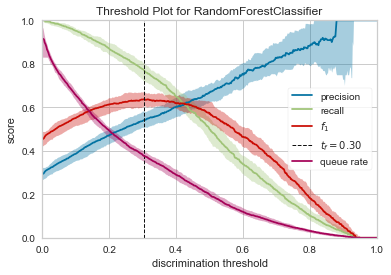

In [36]:
#function attributes
#columns  - column used
#nf_estimators   - The number of trees in the forest.
#estimated_tree  - tree number to be displayed
#maximum_depth   - depth of the tree
#criterion_type  - split criterion type ["gini" or "entropy"]
#Model performance - prints performance of model

def plot_tree_randomforest(columns, nf_estimators,
                           estimated_tree, maximum_depth,
                           criterion_type,model_performance = None) :
    
    dataframe = df_telcom_og[columns + target_col].copy()
    
    #train and test datasets
    rf_x     = dataframe[[i for i in columns if i not in target_col]]
    rf_y     = dataframe[target_col]
    
    #random forest classifier
    rfc   = RandomForestClassifier(n_estimators = nf_estimators,
                                   max_depth = maximum_depth,
                                   criterion = criterion_type,
                                   random_state = 48
                                  )
    rfc.fit(rf_x,rf_y)
    
    estimated_tree = rfc.estimators_[estimated_tree]
    
    #graph = Source(tree.export_graphviz(estimated_tree,out_file=None,
    #                                    rounded=True,proportion = False,
    #                        feature_names = columns, 
    #                        precision  = 2,
    #                        class_names=["Not churn","Churn"],
    #                        filled = True))
    #display(graph)
    
    #model performance
    if model_performance == True :
        telecom_churn_prediction(rfc,
                                 rf_x,test_X[columns],
                                 rf_y,test_Y,
                                 columns,"features", threshold_plot = True)
    return rfc

cols1 = [ i for i in train_X.columns if i not in target_col + Id_col] 
rfc_model = plot_tree_randomforest(cols1, 300, 200, 10, "entropy", True)

In [37]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.5))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

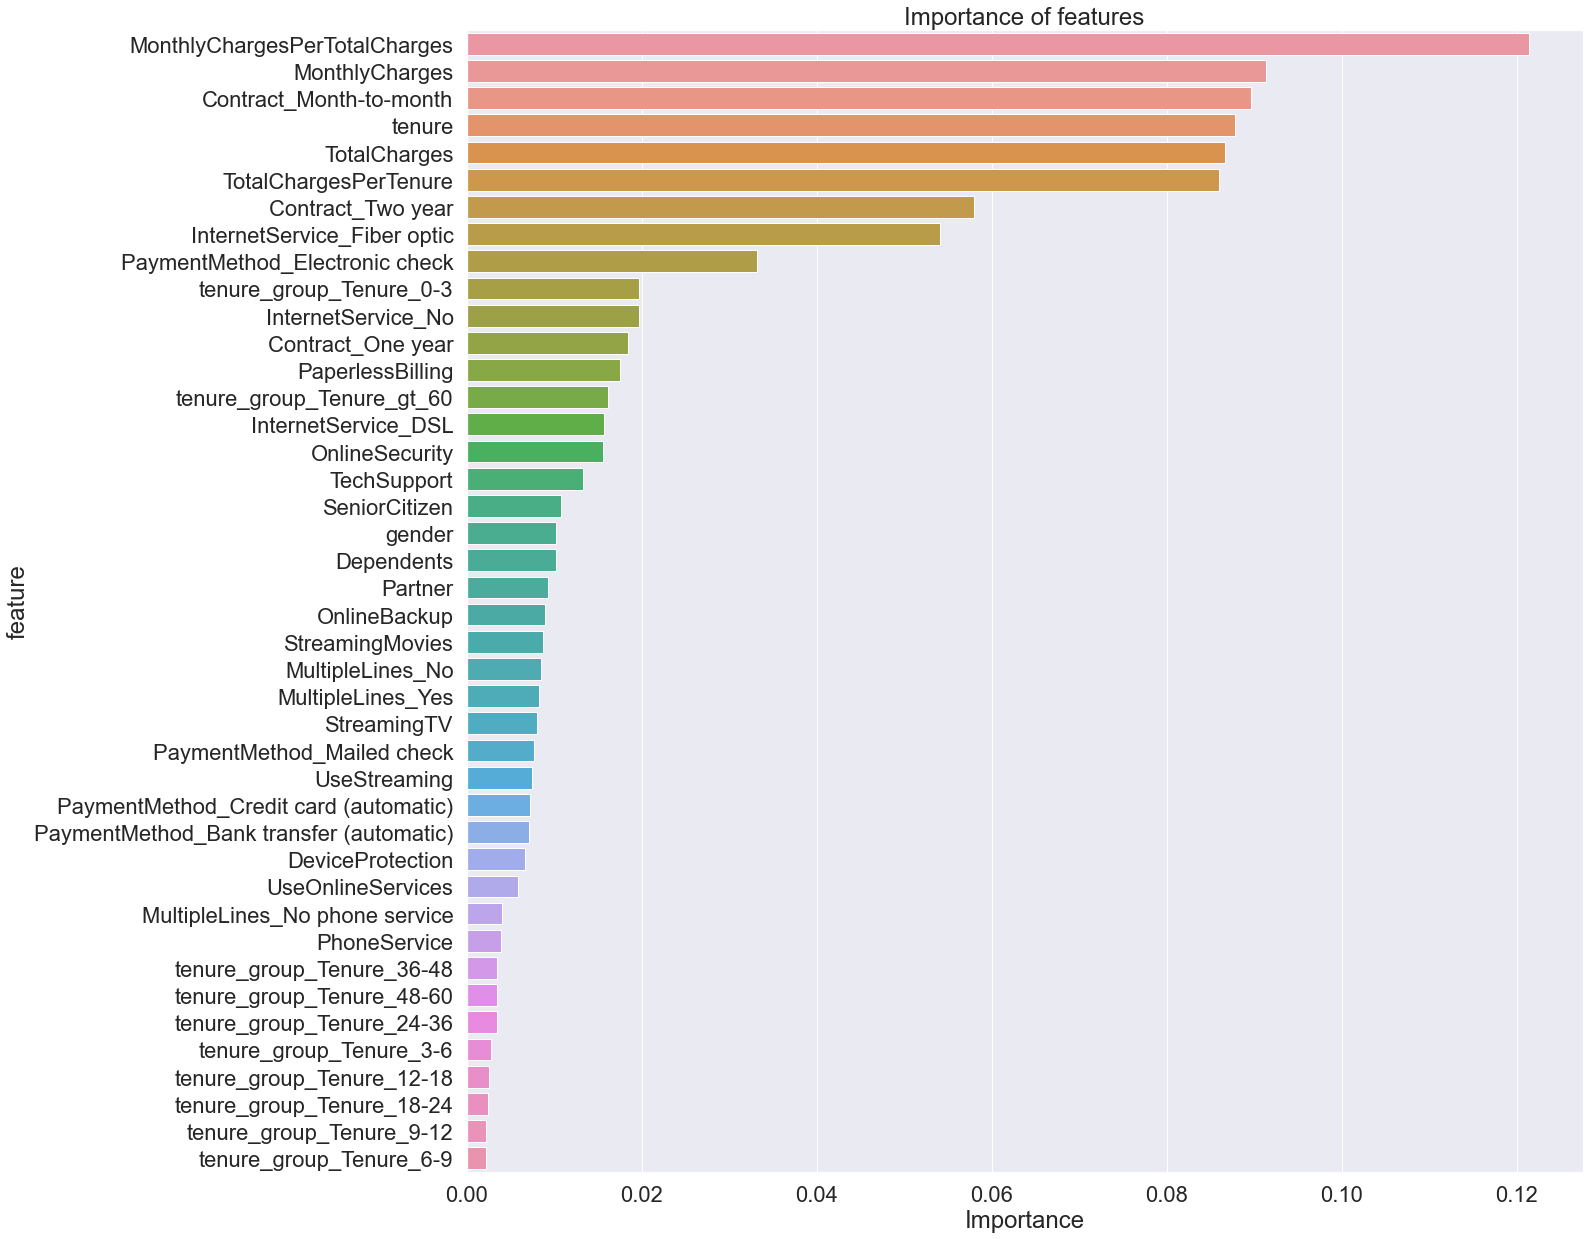

In [38]:
sns.set(font_scale = 2)
important_features_top = show_feature_importances(cols1, rfc_model.feature_importances_, get_top=20)
sns.set(font_scale = 1)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=300,
                       random_state=48)

 Classification report : 
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      1268
           1       0.82      0.66      0.73       490

    accuracy                           0.87      1758
   macro avg       0.85      0.80      0.82      1758
weighted avg       0.86      0.87      0.86      1758

Accuracy   Score :  0.8651877133105802
Area under curve :  0.8032414858687955 



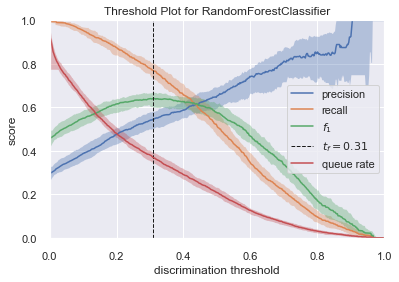

In [39]:
def plot_tree_randomforest(columns, nf_estimators,
                           estimated_tree, maximum_depth,
                           criterion_type,model_performance = None) :
    
    dataframe = df_telcom_og[columns + target_col].copy()
    
    #train and test datasets
    rf_x     = dataframe[[i for i in columns if i not in target_col]]
    rf_y     = dataframe[target_col]
    
    #random forest classifier
    rfc   = RandomForestClassifier(n_estimators = nf_estimators,
                                   max_depth = maximum_depth,
                                   criterion = criterion_type,
                                   random_state = 48
                                  )
    rfc.fit(rf_x,rf_y)
    
    estimated_tree = rfc.estimators_[estimated_tree]
    
    #graph = Source(tree.export_graphviz(estimated_tree,out_file=None,
    #                                    rounded=True,proportion = False,
    #                        feature_names = columns, 
    #                        precision  = 2,
    #                        class_names=["Not churn","Churn"],
    #                        filled = True))
    #display(graph)
    
    #model performance
    if model_performance == True :
        telecom_churn_prediction(rfc,
                                 rf_x,test_X[columns],
                                 rf_y,test_Y,
                                 columns,"features", threshold_plot = True)
        

plot_tree_randomforest(important_features_top, 300, 200, 10, "entropy", True)

2. дополнить список моделей еще как минимум тремя (lightgbm, xgboost, svm, knn, naivebayes, сети, что-то еще)

In [49]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))

### KNN

In [42]:
#train_X,test_X,train_Y,test_Y
scaler = RobustScaler()
X_train = scaler.fit_transform(train_X)
X_train = pd.DataFrame(train_X, columns=cols)

X_test = scaler.fit_transform(test_X)
X_test = pd.DataFrame(test_X, columns=cols)

In [50]:
for n in range(5, 12):
    print('\nNeighbors =', n)
    model_knn = KNeighborsClassifier(n_neighbors=n)
    model_knn.fit(X_train, train_Y)

    y_train_pred = model_knn.predict(X_train)
    y_test_pred = model_knn.predict(X_test)

    get_classification_report(train_Y, y_train_pred, test_Y, y_test_pred)


Neighbors = 5
TRAIN

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      3895
           1       0.74      0.57      0.64      1379

    accuracy                           0.83      5274
   macro avg       0.80      0.75      0.77      5274
weighted avg       0.83      0.83      0.83      5274

TEST

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1268
           1       0.57      0.42      0.48       490

    accuracy                           0.75      1758
   macro avg       0.68      0.65      0.66      1758
weighted avg       0.73      0.75      0.74      1758


Neighbors = 6
TRAIN

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      3895
           1       0.80      0.45      0.58      1379

    accuracy                           0.83      5274
   macro avg       0.82      0.70      0.73      5274
weighted avg       0.82 

Наилучший результат f1 score в KNN достигнут при 11 соседей 

### LightGBM

In [62]:
params = {'n_estimators':[100, 200, 300, 500, 700], 
          'max_depth':[15, 18, 20],
          'l2_leaf_reg': [1, 5, 10],
          'learning_rate':[0.02, 0.05, 0.1, 0.2],
         }

In [63]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [64]:
%%time

model_lgbm = lgbm.LGBMClassifier(silent=True, random_state=21)
rs = GridSearchCV(model_lgbm, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(train_X, train_Y)

Wall time: 1min 17s


GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             estimator=LGBMClassifier(random_state=21), n_jobs=-1,
             param_grid={'l2_leaf_reg': [1, 5, 10],
                         'learning_rate': [0.02, 0.05, 0.1, 0.2],
                         'max_depth': [15, 18, 20],
                         'n_estimators': [100, 200, 300, 500, 700]},
             scoring='f1')

In [65]:
rs.best_params_

{'l2_leaf_reg': 1, 'learning_rate': 0.05, 'max_depth': 18, 'n_estimators': 200}

In [66]:
%%time
# train_X, test_X, train_Y, test_Y

model_lgbm = lgbm.LGBMClassifier(n_estimators=200, max_depth=18, learning_rate=0.05,
                                 silent=True, random_state=21, l2_leaf_reg=1)
model_lgbm.fit(train_X, train_Y)

y_train_pred = model_lgbm.predict(train_X)
y_test_pred = model_lgbm.predict(test_X)

get_classification_report(train_Y, y_train_pred, test_Y, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3895
           1       0.85      0.73      0.78      1379

    accuracy                           0.89      5274
   macro avg       0.88      0.84      0.86      5274
weighted avg       0.89      0.89      0.89      5274

TEST

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1268
           1       0.68      0.52      0.59       490

    accuracy                           0.80      1758
   macro avg       0.76      0.71      0.73      1758
weighted avg       0.79      0.80      0.79      1758

Wall time: 513 ms


### XGBoost

In [67]:
params = {'n_estimators':[100, 200, 300, 500, 700], 
          'max_depth':[15, 18, 20],
          'learning_rate':[0.02, 0.05, 0.1, 0.2],
         }

In [68]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [69]:
%%time

model_xgb = xgb.XGBClassifier(random_state=21)
rs = GridSearchCV(model_xgb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(train_X, train_Y)

Wall time: 6min 53s


GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=21,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
         

In [70]:
rs.best_params_

{'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 100}

In [71]:
%%time

model_xgb = xgb.XGBClassifier(n_estimators=100, max_depth=20, learning_rate=0.05,
                              random_state=21)
model_xgb.fit(train_X, train_Y)

y_train_pred = model_xgb.predict(train_X)
y_test_pred = model_xgb.predict(test_X)

get_classification_report(train_Y, y_train_pred, test_Y, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3895
           1       0.99      0.97      0.98      1379

    accuracy                           0.99      5274
   macro avg       0.99      0.99      0.99      5274
weighted avg       0.99      0.99      0.99      5274

TEST

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1268
           1       0.62      0.48      0.54       490

    accuracy                           0.77      1758
   macro avg       0.72      0.68      0.70      1758
weighted avg       0.76      0.77      0.76      1758

Wall time: 1.24 s


### CatBoost

In [73]:
%%time

model_catb = catb.CatBoostClassifier(n_estimators=200, max_depth=15, learning_rate=0.05,
                                     silent=True, random_state=21, l2_leaf_reg=1)
model_catb.fit(train_X, train_Y)

y_train_pred = model_catb.predict(train_X)
y_test_pred = model_catb.predict(test_X)

get_classification_report(train_Y, y_train_pred, test_Y, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3895
           1       0.99      0.99      0.99      1379

    accuracy                           1.00      5274
   macro avg       0.99      0.99      0.99      5274
weighted avg       1.00      1.00      1.00      5274

TEST

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1268
           1       0.64      0.46      0.53       490

    accuracy                           0.78      1758
   macro avg       0.72      0.68      0.69      1758
weighted avg       0.76      0.78      0.76      1758

Wall time: 1min 46s


### Performance evaluation

In [79]:
%%time
#gives model report in dataframe
def model_report(model, training_x, testing_x, training_y, testing_y,name, cols=None):
    if cols:
        training_x = training_x[cols]
        testing_x = testing_x[cols]
    model.fit(training_x, training_y)
    predictions  = model.predict(testing_x)
    accuracy     = accuracy_score(testing_y,predictions)
    recallscore  = recall_score(testing_y,predictions)
    precision    = precision_score(testing_y,predictions)
    roc_auc      = roc_auc_score(testing_y,predictions)
    f1score      = f1_score(testing_y,predictions) 
    kappa_metric = cohen_kappa_score(testing_y,predictions)
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                       "Area_under_curve": [roc_auc],
                       "Kappa_metric"    : [kappa_metric],
                      })
    return df

#outputs for every model
model1 = model_report(logit_simple, train_X, test_X, train_Y, test_Y,
                      "Logistic Regression(Baseline_model)")
model2 = model_report(logit_smote, os_smote_X, test_X, os_smote_Y, test_Y,
                      "Logistic Regression(SMOTE)")
model3 = model_report(logit_rfe, train_rf_X, test_rf_X, train_rf_Y, test_rf_Y,
                      "Logistic Regression(RFE)")


rfc = RandomForestClassifier(n_estimators = 600,
                             random_state = 48,
                             max_depth = 10,
                             criterion = "entropy")
model4 = model_report(rfc, train_X, test_X, train_Y, test_Y,
                      "Random Forest Classifier")
rfc = RandomForestClassifier(n_estimators = 600,
                             random_state = 48,
                             max_depth = 10,
                             criterion = "entropy")
model5 = model_report(rfc, os_smote_X, test_X, os_smote_Y, test_Y,
                      "Random Forest Classifier (SMOTE)")
rfc = RandomForestClassifier(n_estimators = 600,
                             random_state = 48,
                             max_depth = 10,
                             criterion = "entropy")
model6 = model_report(rfc, train_X, test_X, train_Y, test_Y,
                      "Random Forest Classifier (Important features)", important_features_top)


model7 = model_report(model_knn, train_X, test_X, train_Y, test_Y,
                      "KNN")

model8 = model_report(model_lgbm, train_X, test_X, train_Y, test_Y,
                      "LightGBM")

model9 = model_report(model_xgb, train_X, test_X, train_Y, test_Y,
                      "XGBoost")

model10 = model_report(model_catb, train_X, test_X, train_Y, test_Y,
                      "CatBoost")

#concat all models
model_performances = pd.concat([model1, model2, model3,
                                model4, model5, model6,
                                model7, model8, model9, model10],axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index",axis =1)

table  = ff.create_table(np.round(model_performances, 4))

py.iplot(table)

Wall time: 2min


3. на выходе сформировать единую таблицу метрик качества со всеми моделями 

In [80]:
model_performances

Model  Accuracy_score  \
0            Logistic Regression(Baseline_model)        0.800910   
1                     Logistic Regression(SMOTE)        0.789534   
2                       Logistic Regression(RFE)        0.793515   
3                       Random Forest Classifier        0.799772   
4               Random Forest Classifier (SMOTE)        0.782708   
5  Random Forest Classifier (Important features)        0.806598   
6                                            KNN        0.772469   
7                                       LightGBM        0.798635   
8                                        XGBoost        0.773606   
9                                       CatBoost        0.776451   

   Recall_score  Precision  f1_score  Area_under_curve  Kappa_metric  
0      0.514286   0.692308  0.590164          0.712979      0.462438  
1      0.597959   0.628755  0.612971          0.730762      0.468565  
2      0.624490   0.630928  0.627692          0.741661      0.484840  
3      0.465306   0.716981  0.564356          0.697164      0.441917  
4      0.689796   0.595070  0.638941          0.754204      0.484736  
5      0.493878   0.724551  0.587379          0.710661      0.466927  
6      0.404082   0.647059  0.497487          0.659454      0.360430  
7      0.522449   0.680851  0.591224          0.713906      0.460693  
8      0.483673   0.620419  0.543578          0.684660      0.396104  
9      0.461224   0.636620  0.534911          0.679745      0.392679

4. сделать выводы о том, какие модели лучше справляются с задачей прогноза оттока на этой выборке

#### Наилучшее значение f1 score и roc auc у модели Random Forest с балансировкой классов по SMOTE

5. есть ли смысл в этапе отборе признаков с точки зрения повышения качества прогнозов

__Да, есть и с точки зрения повышения качества, и с точки зрения уменьшения времени обучения__

6. (опционально) сделать подбор параметров (без особого усердия) для лучшей (можно нескольких) моделей и проверить качество снова

In [81]:
#os_smote_X, test_X, os_smote_Y, test_Y
parameters = {
    'n_estimators': [100, 200, 300, 500],
    'max_features': np.arange(14, 18),
    'max_depth': np.arange(14, 18),
}

clf = GridSearchCV(
    estimator=RandomForestClassifier(criterion='entropy'),
    param_grid=parameters,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

In [82]:
%%time
clf.fit(os_smote_X, os_smote_Y)

Wall time: 5min 48s


GridSearchCV(cv=5, estimator=RandomForestClassifier(criterion='entropy'),
             n_jobs=-1,
             param_grid={'max_depth': array([14, 15, 16, 17]),
                         'max_features': array([14, 15, 16, 17]),
                         'n_estimators': [100, 200, 300, 500]},
             scoring='f1_macro')

In [83]:
clf.best_params_

{'max_depth': 16, 'max_features': 15, 'n_estimators': 100}

RandomForestClassifier(criterion='entropy', max_depth=16, max_features=15)

 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.86      0.85      1268
           1       0.61      0.56      0.58       490

    accuracy                           0.78      1758
   macro avg       0.72      0.71      0.71      1758
weighted avg       0.77      0.78      0.77      1758

Accuracy   Score :  0.7753128555176336
Area under curve :  0.708382154123479 



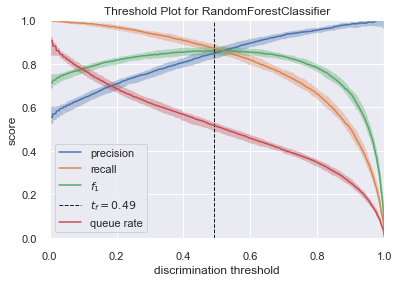

Wall time: 1min 19s


In [86]:
%%time

model_rf_final = RandomForestClassifier(max_depth=16, 
                             max_features=15,
                             n_estimators=100, 
                             criterion='entropy'
                            )
model_rf_final.fit(train_X, train_Y)

y_train_pred = model_xgb.predict(train_X)
y_test_pred = model_xgb.predict(test_X)

telecom_churn_prediction(model_rf_final, os_smote_X, test_X, os_smote_Y, test_Y, cols, "features", threshold_plot = True)

#### Судя по данным выше подбор параметров сделал модель только хуже - f1 score и roc auc стал ниже